## I - Initialisation </br>
Import des librairies et modules

In [36]:

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder


## II - Lecture et conversion des jeux de données </br>
- Csv -> DataFrame </br>
- Fusion des deux jeux de données

In [ ]:

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test['Survived'] = None
full = pd.concat([train, test], sort=False)
print(full)


     PassengerId Survived  Pclass  \
0              1        0       3   
1              2        1       1   
2              3        1       3   
3              4        1       1   
4              5        0       3   
..           ...      ...     ...   
413         1305     None       3   
414         1306     None       1   
415         1307     None       3   
416         1308     None       3   
417         1309     None       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
41

## III - Traitement des données </br>
- Extraction des titres dans 'Name' et création d'une colonne 'Title' </br>
- Remplacement des données manquantes : l'âge est déterminé par médiane par groupe </br>
- Encodage des données de type 'str' en valeurs numériques utilisables par les modèles d'entrainement </br>
- Suppression des colonnes (jugées) inutiles à l'analyse : 'Name', 'Ticket', 'Cabin'

In [38]:

# Extraction titre
full['Title'] = full['Name'].str.extract(r',\s*([^\.]*)\s*\.', expand=False).str.strip()

# Remplissage des âges manquants par médiane par groupe
age_medians = full.groupby(['Title', 'Pclass'])['Age'].median()
def impute_age(row):
    if pd.isnull(row['Age']):
        return age_medians.get((row['Title'], row['Pclass']), full['Age'].median())
    return row['Age']
full['Age'] = full.apply(impute_age, axis=1)

# Encodage des variables catégorielles
le = LabelEncoder()
full['Sex'] = le.fit_transform(full['Sex'])
full['Title'] = le.fit_transform(full['Title'])
full['Embarked'] = full['Embarked'].fillna(full['Embarked'].mode()[0])
full['Embarked'] = le.fit_transform(full['Embarked'])

# Remplissage de 'Fare'
full['Fare'] = full['Fare'].fillna(full['Fare'].median())

# Suppression des colonnes inutiles
full.drop(columns=['Cabin', 'Ticket', 'Name'], inplace=True)


## IV - Séparation des données en deux groupes </br>
- train_cleaned = contient uniquement les lignes avec une valeur connue pour 'Survived'(utilisé pour entrainer le modèle)
- test_cleaned = contient les lignes sans valeur de 'Survived' (utilisé pour faire des prédictions)

In [39]:
train_cleaned = full[full['Survived'].notnull()]
test_cleaned = full[full['Survived'].isnull()]

## V - Sélection des features et de la target

In [40]:

features = ['Age', 'Sex', 'Pclass', 'Title', 'Parch', 'Fare', 'SibSp']
X = train_cleaned[features]
y = train_cleaned['Survived'].astype(int)


## VI - Division des données en 2 groupes </br>
- 80% pour l'entrainement, 20% pour le test

In [41]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


## VII - Entrainement du modèle

In [42]:

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


## VIII - Evaluation </br>


In [43]:

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7988826815642458
[[95 11]
 [25 48]]
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       106
           1       0.81      0.66      0.73        73

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.78       179
weighted avg       0.80      0.80      0.79       179



VIII.bis - Interprétation des résultats

- L'accuracy (précision) est estimée à 79~80%


- La matrice de confusion : 96 Vrais Positif (prédits vivants et vivants) / 10 Faux Positifs (prédits vivants et morts) / 26 Faux Négatifs (prédits morts et vivants) / 47 Vrais Négatifs (prédits morts et morts)

Classification report

- Classe 0 (mort) </br>
1- Précision : 79% de bonnes prédictions sur les passagers effectivement mortes </br>
2- Recall : Sur l'ensemble des vrais morts, 91% ont bien été prédits </br>
3- F1-score : Moyenne entre precision et recall (84%)

- Classe 1 (vivant) </br>
1- Précision : 82% de bonnes prédictions sur les passagers effectivement vivants </br>
2- Recall : Sur l'ensemble des vrais vivants, 64% ont bien été prédits </br>
3- F1-score : Moyenne entre precision et recall (72%)

## Synthèse - 1er entrainement</br>
Le modèle a une précision de 80%, ce qui signifie que sur 10 passagers, 8 ont reçus une prédiction en adéquation avec les données réelles. </br>
On constate avec la matrice de confusion que le modèle est efficace pour prédire les morts (96/106) mais a des difficultés à prédire les survivants (47/73) avec en faux négatif 26 individus. </br>
Le rapport de classification indique un rappel (recall) pour les morts élévé (0.91) mais plus faible pour les survivants (0.64). Ce qui peut se traduire par une tendance à prédire plus souvent la mort d'un passager. </br>
En bref, le modèle est efficace en ce qui concerne la prédiction des morts mais doit être amélioré pour prédire les survivants.


IX - Exportation des résultats

In [44]:

X_test_final = test_cleaned[features]


y_pred_final = model.predict(X_test_final)
submission = test_cleaned[['PassengerId']].copy()
submission['Survived'] = y_pred_final.astype(int)
submission.to_csv('submission.csv', index=False)


## X - Recherche de meilleurs hyperparamètres 

In [47]:
from sklearn.model_selection import GridSearchCV
#  Définition des hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 200, 300], # nb d'arbres
    'max_depth': [None, 5, 10], # profondeur max.
    'min_samples_split': [2, 5, 10], # min d'échantillons pour la division des noeuds
    'min_samples_leaf': [1, 2, 4] # min d'échantillons dans une feuille
}
#  Création du GridSearch

grid = GridSearchCV(
    estimator= RandomForestClassifier(random_state=1),
    param_grid= param_grid,
    cv= 5, # cross validation - 5 plis
    scoring='accuracy', # critère utilisé pour évaluer
    verbose=1, # pour afficher la progression
    n_jobs=1 # utilise tous les coeurs du processeur
)

grid.fit(X, y)

print("Meilleurs paramètres : ", grid.best_estimator_)
print("Meilleure précision : ", grid.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Meilleurs paramètres :  RandomForestClassifier(min_samples_leaf=2, min_samples_split=10,
                       n_estimators=300, random_state=1)
Meilleure précision :  0.8372795179210344


## XI - Utilisation des hyperparamètres recommandés </br>
- Nombres d'échantillons minimal dans une feuille : 2
- Nombres d'échantillons minimal pour la division des noeuds : 10
- Nombres d'arbres optimal : 300


In [48]:
best_model = grid.best_estimator_
# Prédiction à partir du meilleur modèle
y_pred = best_model.predict(X_test)
#  Evaluation
print('Accuracy : ', accuracy_score(y_test, y_pred))
print('Matrice de confusion : ',confusion_matrix(y_test, y_pred))
print('Rapport de classification : ', classification_report(y_test, y_pred))

Accuracy :  0.9106145251396648
Matrice de confusion :  [[101   5]
 [ 11  62]]
Rapport de classification :                precision    recall  f1-score   support

           0       0.90      0.95      0.93       106
           1       0.93      0.85      0.89        73

    accuracy                           0.91       179
   macro avg       0.91      0.90      0.91       179
weighted avg       0.91      0.91      0.91       179



Exportation des résultats

In [56]:
y_test_pred = best_model.predict(test_cleaned[features])
submission_final = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': y_pred_final.astype(int)
})
submission_final.to_csv('submission_finale.csv', index=False)

## Synthèse - Entrainement "optimisé" 

Le modèle a une précision (accuracy) sur la prédiction d'environ 91%. </br>
Selon la matrice de confusion (cf. XII - Visualisation des données/- Matrice de confusion), le modèle prédit 101 vrais positifs (mort prédit mort) et 62 vrai négatifs (vivants prédits vivants). Cependant, il y a 11 survivants prédits morts (faux positif) et 5 morts réels prédits survivants. </br>
Enfin, le rapport de classification constate une précision (Precision) de 93%. Autrement dit, parmi tous ceux prédits comme survivants, il y a 93% qui le sont. Le recall s'élève à 85%, soit 85% de vrais survivants correctement retrouvés. Le f1-score1 (moyenne de la precsion et du recall) est de 89%. </br>
A l'image du premier test, le modèle semble prédire plus efficacement le décès d'un passager plutôt que sa survie.

## XII - Visualisation des données

### - Relation entre variables et cible (Survived)

1 - Survie en fonction du sexe

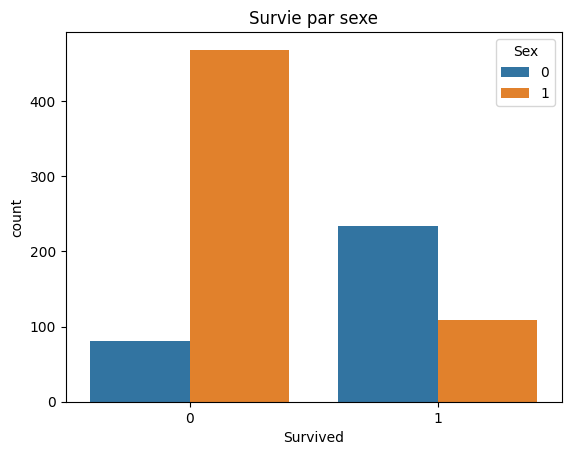

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='Survived',
              hue='Sex',
              data=train_cleaned)
plt.title('Survie par sexe')
plt.show()

2 - Survie en fonction du Passager Class (Pclass)

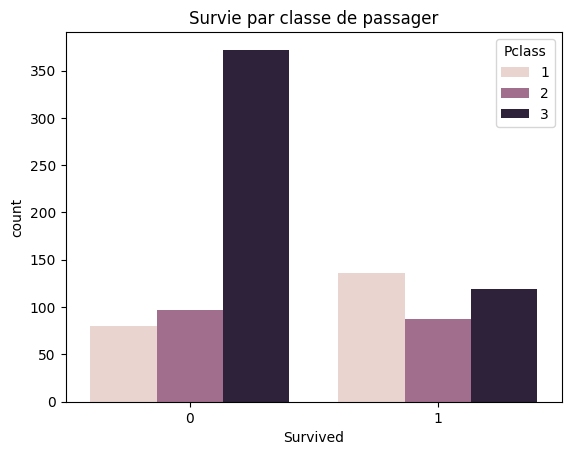

In [52]:
sns.countplot(x='Survived',
              hue='Pclass',
              data=train_cleaned)
plt.title("Survie par classe de passager")
plt.show()

3 - Survie en fonction de l'âge

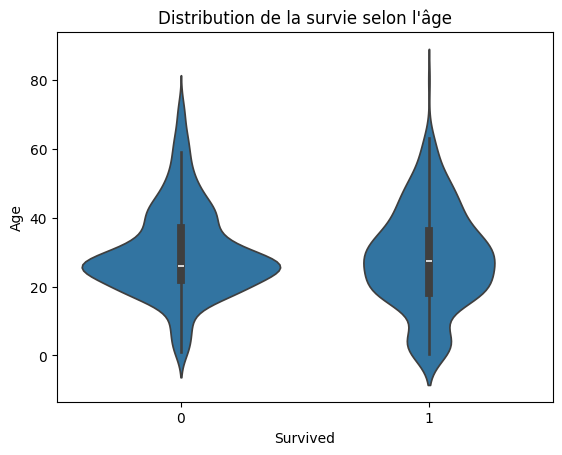

In [53]:
sns.violinplot(x='Survived',
               y='Age',
               data=train_cleaned)
plt.title('Distribution de la survie selon l\'âge')
plt.show()

### - Matrice de confusion

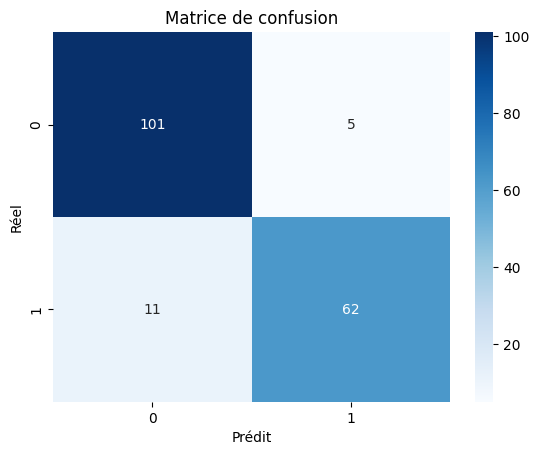

In [54]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, 
            annot=True,
            fmt='d',
            cmap='Blues'
            )
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()

### - Importance des variables

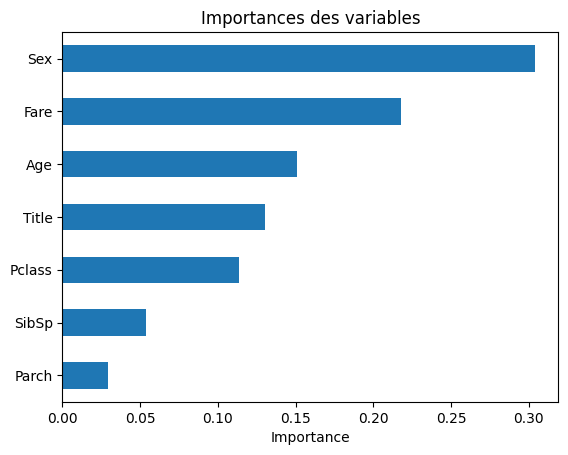

In [55]:
importances = pd.Series(best_model.feature_importances_,
                        index=X.columns)
importances.sort_values().plot(kind='barh')
plt.title('Importances des variables')
plt.xlabel('Importance')
plt.show()